# Import libraries

In [1]:

from src.preprocessing.dataLoader_CelebA import get_partitioned_dataloaders, create_subset_loader
from src.preprocessing.dataLoader_vi import SiameseNetworkDataset
from src.ml.resNet18 import SiameseNetwork
from src.ml.loss_utils import ContrastiveLoss, ArcFaceLoss, MultiSimilarityLoss
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import torch
import torchvision
import torch.nn.functional as F

# 1. Load the data

In [2]:
import yaml

# Load config from YAML
with open("config/config.yml", "r") as f:
    config = yaml.safe_load(f)

# Extract sections
PRE = config["PREPROCESSING"]
TRAIN = config["TRAINING"]

# Set constants from preprocessing config
IMAGE_DIR = PRE["image_dir"]
LABEL_FILE = PRE["label_file"]
PARTITION_FILE = PRE["partition_file"]
BATCH_SIZE = PRE["batch_size"]
M_PER_SAMPLE = PRE["m_per_sample"]
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set constants from training config
LR = TRAIN["lr"]
SCHEDULING = TRAIN["scheduling"]
WEIGHT_DECAY = TRAIN["weight_decay"]
NUM_EPOCHS = TRAIN["num_epochs"]
PATIENCE = TRAIN["patience"]
LOSS_TYPE = TRAIN["loss_type"]
DATASET_NAME = "celebA"# "celebA" # ATT
NUM_IDENTITY = 200

In [3]:
def plot_all(train_loader):
    # Assuming train_loader uses FilteredCelebADataset with remapped labels

    # Access the underlying dataset from train_loader
    train_dataset = train_loader.dataset

    # Collect one example image per unique label
    unique_labels = sorted(set(train_dataset.labels))
    label_to_img = {}

    for idx, label in enumerate(train_dataset.labels):
        if label not in label_to_img:
            label_to_img[label] = train_dataset[idx][0]  # Assuming dataset[idx] returns (image, label)

    # Plot all unique labels with their example images
    num_labels = len(unique_labels)
    cols = 10
    rows = (num_labels + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(cols*2, rows*2))
    axes = axes.flatten()

    for i, label in enumerate(unique_labels):
        img = label_to_img[label].permute(1, 2, 0).numpy()

        # Denormalize (if your dataset applies normalization)
        mean = [0.485, 0.456, 0.406]
        std = [0.229, 0.224, 0.225]
        img = img * std + mean
        img = img.clip(0, 1)

        axes[i].imshow(img)
        axes[i].set_title(f"Label: {label}")
        axes[i].axis('off')

    # Hide unused subplots
    for j in range(i+1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()


In [4]:
if DATASET_NAME == "celebA":
    # Load datasets
    train_loader, val_loader, test_loader = get_partitioned_dataloaders(
        image_dir=IMAGE_DIR,
        label_file=LABEL_FILE,
        partition_file=PARTITION_FILE,
        m_per_sample=M_PER_SAMPLE,
        batch_size=BATCH_SIZE,
        num_identities=NUM_IDENTITY,
        seed=42
    )
    # plot_all(train_loader=train_loader)
else:
    # Load the training dataset
    folder_dataset = datasets.ImageFolder(root="data/v2/data/faces/training/")

    # Resize the images and transform to tensors
    transformation = transforms.Compose([transforms.Resize((100,100)),
                                        transforms.ToTensor()
                                        ])

    # Initialize the network
    siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset,
                                            transform=transformation)
    train_loader = DataLoader(siamese_dataset, shuffle=True, num_workers=0, batch_size=BATCH_SIZE)

    # Locate the test dataset and load it into the SiameseNetworkDataset
    folder_dataset_test = datasets.ImageFolder(root="data/v2/data/faces/testing/")
    siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset_test,
                                            transform=transformation)
    test_loader = DataLoader(siamese_dataset, num_workers=0, batch_size=1, shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.5877128].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.1804092].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6051416].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.2042704].


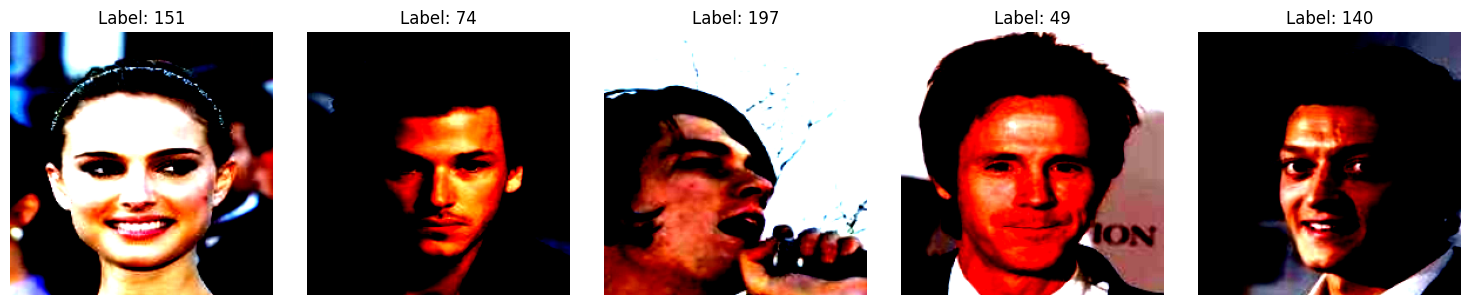

In [5]:
import matplotlib.pyplot as plt
import torch

plt.figure(figsize=(15, 3))

for i in range(5):
    sample = test_loader.dataset[i]
    image, label = sample[0], sample[3]  # image is first, label is fifth

    # Convert image to numpy
    if isinstance(image, torch.Tensor):
        if image.ndim == 3 and image.shape[0] == 1:  # grayscale
            image = image.squeeze().numpy()
            cmap = 'gray'
        elif image.ndim == 3 and image.shape[0] == 3:  # RGB
            image = image.permute(1, 2, 0).numpy()
            cmap = None
        else:
            raise ValueError(f"Unexpected image shape: {image.shape}")
    else:
        cmap = 'gray'

    # Convert label to int
    if isinstance(label, torch.Tensor):
        label = label.item()

    plt.subplot(1, 5, i + 1)
    plt.imshow(image, cmap=cmap)
    plt.title(f"Label: {label}")
    plt.axis('off')

plt.tight_layout()
plt.show()


# Create the model

In [6]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = SiameseNetwork().to(DEVICE)

# Train Model

In [7]:
loss_type = LOSS_TYPE

if loss_type == "contrastive":
    criterion = ContrastiveLoss(margin=20).to(DEVICE)
elif loss_type == "arcface":
    criterion = ArcFaceLoss(num_classes=NUM_IDENTITY, embedding_size=256).to(DEVICE)
elif loss_type == "multisimilarity":
    import pytorch_metric_learning.losses as losses
    criterion = losses.MultiSimilarityLoss(alpha=2, beta=50, base=0.5).to(DEVICE)
optimizer = torch.optim.Adam(net.parameters(), lr=0.0009)


In [8]:
# Showing images
def imshow(img, text=None):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
        
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

# Plotting data
def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

In [9]:
import random
import numpy as np
import torch

def set_seed(seed=42):
    random.seed(seed)                      # Python random module
    np.random.seed(seed)                   # NumPy
    torch.manual_seed(seed)                # PyTorch CPU
    torch.cuda.manual_seed(seed)           # PyTorch GPU (single GPU)
    torch.cuda.manual_seed_all(seed)       # PyTorch GPU (all GPUs if you use DataParallel)
    
    # For deterministic behavior (may be slower)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Call this once at the start of your script (before model init and training)
# set_seed(1234)

In [ ]:
from tqdm import tqdm

counter = []
loss_history = [] 
iteration_number = 0
NUM_EPOCHS = 200

# Iterate through the epochs
for epoch in range(NUM_EPOCHS):
    cum_loss = 0
    print(f"\nEpoch {epoch + 1}/{NUM_EPOCHS}")
    
    # tqdm progress bar for batches
    pbar = tqdm(enumerate(train_loader, 0), total=len(train_loader), desc=f"Training Epoch {epoch+1}")
    
    for i, (img0, img1, label, label0, label1) in pbar:
        # Send the images and labels to DEVICE
        img0, img1, label, label0, label1 = img0.to(DEVICE), img1.to(DEVICE), label.to(DEVICE), label0.to(DEVICE), label1.to(DEVICE)
        
        optimizer.zero_grad()
        output1, output2 = net(img0, img1)

        # Compute loss
        if loss_type == "contrastive":
            loss = criterion(output1, output2, label)
        elif loss_type == "multisimilarity":
            embeddings = torch.cat([output1, output2])
            labels = torch.cat([label0, label1])
            loss = criterion(embeddings, labels)
        elif loss_type == "arcface":
            loss = criterion(output1, output2, label0, label1)

        loss.backward()
        optimizer.step()
        
        cum_loss += loss.item()

        # Logging every 10 batches
        if i % 10 == 0:
            iteration_number += 10
            counter.append(iteration_number)
            loss_history.append(loss.item())
        
        # Update tqdm description
        pbar.set_postfix({'Avg Loss': cum_loss / (i + 1)})

show_plot(counter, loss_history)



Epoch 1/200


Training Epoch 1: 100%|██████████| 43/43 [00:13<00:00,  3.23it/s, Avg Loss=85.3]



Epoch 2/200


Training Epoch 2: 100%|██████████| 43/43 [00:12<00:00,  3.53it/s, Avg Loss=73.1]



Epoch 3/200


Training Epoch 3: 100%|██████████| 43/43 [00:11<00:00,  3.66it/s, Avg Loss=71.2]



Epoch 4/200


Training Epoch 4: 100%|██████████| 43/43 [00:11<00:00,  3.67it/s, Avg Loss=70.1]



Epoch 5/200


Training Epoch 5: 100%|██████████| 43/43 [00:11<00:00,  3.66it/s, Avg Loss=68.6]



Epoch 6/200


Training Epoch 6: 100%|██████████| 43/43 [00:11<00:00,  3.73it/s, Avg Loss=67.2]



Epoch 7/200


Training Epoch 7: 100%|██████████| 43/43 [00:11<00:00,  3.69it/s, Avg Loss=67.4]



Epoch 8/200


Training Epoch 8: 100%|██████████| 43/43 [00:11<00:00,  3.72it/s, Avg Loss=65.3]



Epoch 9/200


Training Epoch 9: 100%|██████████| 43/43 [00:11<00:00,  3.68it/s, Avg Loss=64.5]



Epoch 10/200


Training Epoch 10: 100%|██████████| 43/43 [00:11<00:00,  3.70it/s, Avg Loss=63.8]



Epoch 11/200


Training Epoch 11: 100%|██████████| 43/43 [00:11<00:00,  3.70it/s, Avg Loss=66.6]



Epoch 12/200


Training Epoch 12: 100%|██████████| 43/43 [00:12<00:00,  3.48it/s, Avg Loss=63.3]



Epoch 13/200


Training Epoch 13: 100%|██████████| 43/43 [00:11<00:00,  3.73it/s, Avg Loss=61.1]



Epoch 14/200


Training Epoch 14: 100%|██████████| 43/43 [00:11<00:00,  3.76it/s, Avg Loss=62.3]



Epoch 15/200


Training Epoch 15: 100%|██████████| 43/43 [00:11<00:00,  3.75it/s, Avg Loss=61.8]



Epoch 16/200


Training Epoch 16: 100%|██████████| 43/43 [00:12<00:00,  3.49it/s, Avg Loss=62.7]



Epoch 17/200


Training Epoch 17: 100%|██████████| 43/43 [00:11<00:00,  3.72it/s, Avg Loss=64.2]



Epoch 18/200


Training Epoch 18: 100%|██████████| 43/43 [00:11<00:00,  3.80it/s, Avg Loss=60.5]



Epoch 19/200


Training Epoch 19: 100%|██████████| 43/43 [00:11<00:00,  3.85it/s, Avg Loss=60]  



Epoch 20/200


Training Epoch 20: 100%|██████████| 43/43 [00:12<00:00,  3.50it/s, Avg Loss=61.6]



Epoch 21/200


Training Epoch 21: 100%|██████████| 43/43 [00:11<00:00,  3.79it/s, Avg Loss=60.4]



Epoch 22/200


Training Epoch 22: 100%|██████████| 43/43 [00:11<00:00,  3.82it/s, Avg Loss=60]  



Epoch 23/200


Training Epoch 23:  98%|█████████▊| 42/43 [00:11<00:00,  3.70it/s, Avg Loss=59.2]

# TEST

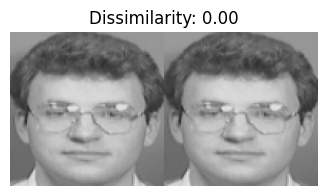

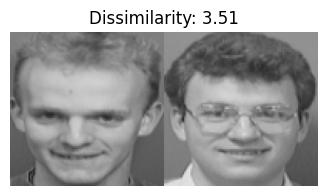

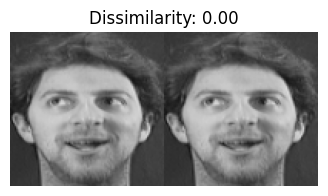

In [ ]:
def imshow(img, title=None):
    npimg = img.numpy()
    plt.figure(figsize=(4, 2))
    plt.axis("off")
    if title:
        plt.title(title)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

import torch
import torch.nn.functional as F

# Assuming your model class is defined as 'Net' (replace with your actual class)
net = SiameseNetwork().to(DEVICE)
checkpoint = torch.load('models/siamese_checkpoint.pth', map_location=DEVICE)
net.load_state_dict(checkpoint['model_state_dict'])

# Set your model to eval mode
net.eval()

for i in range(3):
    # Get one sample (batch of 1)
    img1, img2, _, label1, label2 = next(iter(test_loader))

    # Optional: move to GPU if needed

    # Get embeddings
    with torch.no_grad():
        emb1, emb2 = net(img1.to(DEVICE), img2.to(DEVICE))
        euclidean_distance = F.pairwise_distance(emb1, emb2)

    # Concatenate images for display
    concatenated = torch.cat((img1[0], img2[0]), 2)  # side by side: concat on width (dim=2)
    imshow(torchvision.utils.make_grid(concatenated), f'Dissimilarity: {euclidean_distance.item():.2f}')


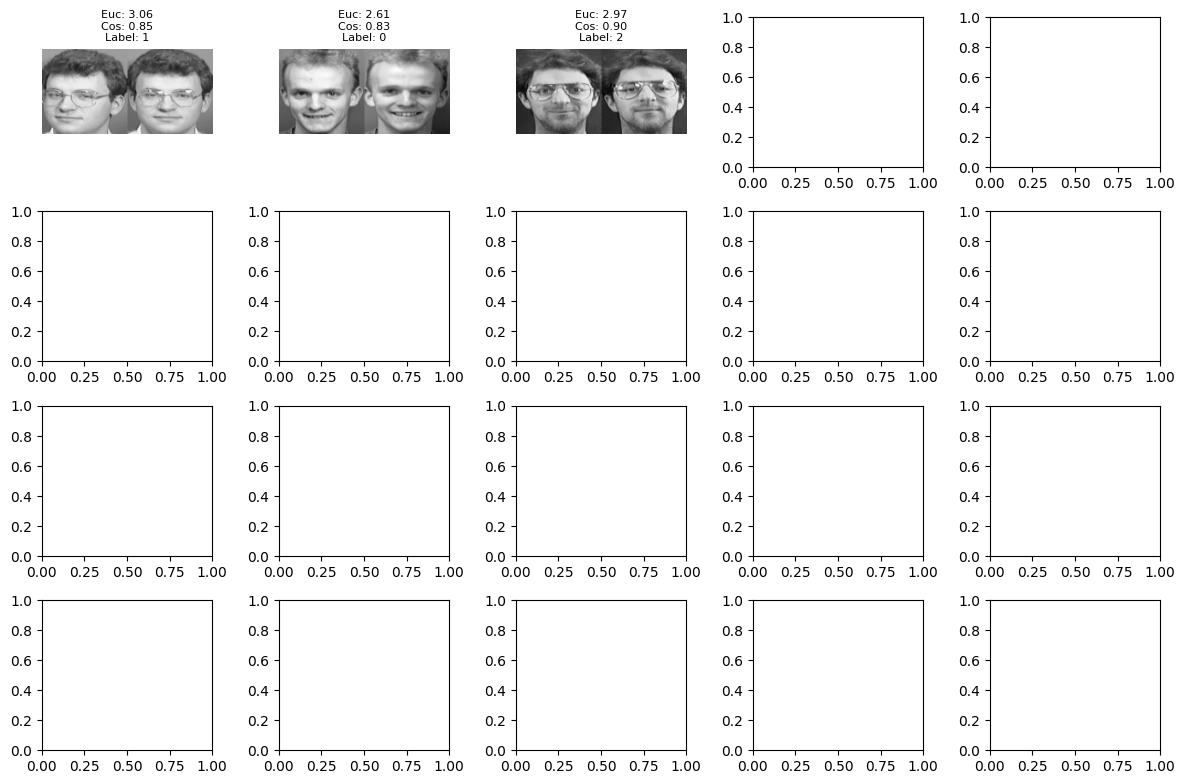

In [ ]:
# CHAT TEST
from collections import defaultdict

# 1. Alle Bilder aus test_dataloader einmalig laden und nach Label gruppieren
label_to_images = defaultdict(list)

for img, _, _, label, _ in test_loader:
    label_to_images[label.item()].append(img)

# 2. Jetzt 20 Paare mit gleichem Label erzeugen
fig, axs = plt.subplots(4, 5, figsize=(12, 8))
axs = axs.flatten()

net.eval()

i = 0
for label, images in label_to_images.items():
    if len(images) < 2:
        continue  # brauchen mindestens 2 Bilder mit gleichem Label

    # Erzeuge z. B. 2 zufällige Bilder dieses Labels
    img1 = images[0].to(DEVICE)
    img2 = images[1].to(DEVICE)

    with torch.no_grad():
        emb1, emb2 = net(img1, img2)
        euclidean_distance = F.pairwise_distance(emb1, emb2)
        cosine_sim = F.cosine_similarity(emb1, emb2)

    img1_gray = img1[0, 0].cpu()
    img2_gray = img2[0, 0].cpu()
    concatenated = torch.cat((img1_gray, img2_gray), dim=1)

    axs[i].imshow(concatenated.numpy(), cmap="gray")
    axs[i].set_title(
        f"Euc: {euclidean_distance.item():.2f}\nCos: {cosine_sim.item():.2f}\nLabel: {label}",
        fontsize=8
    )
    axs[i].axis("off")

    i += 1
    if i >= 20:
        break

plt.tight_layout()
plt.show()


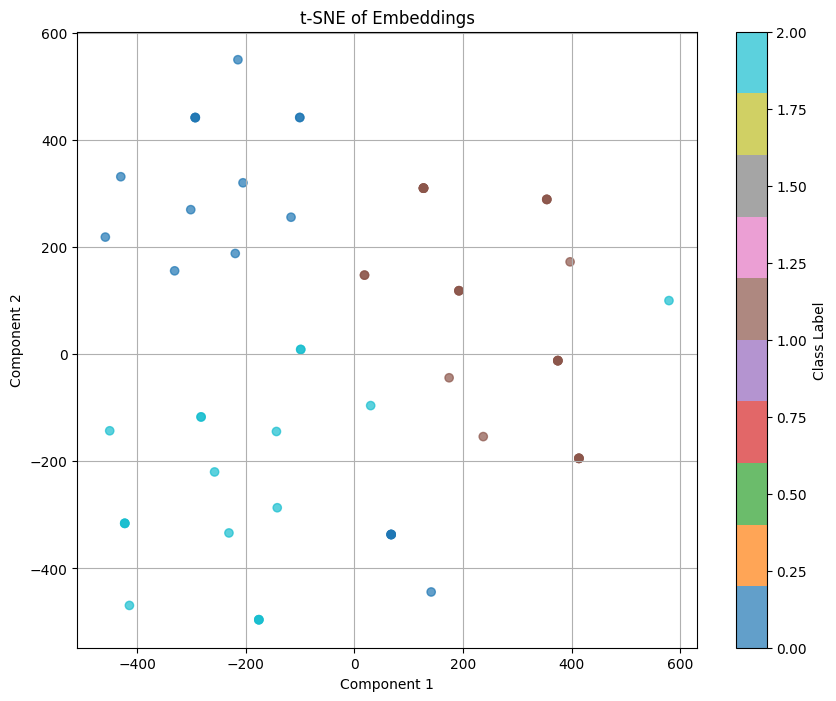

In [ ]:
import matplotlib.pyplot as plt
import torchvision
import torch
import torch.nn.functional as F
from sklearn.manifold import TSNE
import numpy as np

embeddings = []
labels = []

# Collect N samples
N = 200  # or more for better visualization
iterator1 = iter(test_loader)
iterator2 = iter(test_loader)

for _ in range(N):
    try:
        img1, _, _, label1, _ = next(iterator1)
        img2, _, _, label2, _ = next(iterator2)
    except StopIteration:
        break

    with torch.no_grad():
        emb1, emb2 = net(img1.to(DEVICE), img2.to(DEVICE))

    # Collect embeddings and labels
    embeddings.append(emb1.squeeze(0).cpu().numpy())
    labels.append(label1.item())

    embeddings.append(emb2.squeeze(0).cpu().numpy())
    labels.append(label2.item())

# Convert to numpy arrays
embeddings = np.array(embeddings)
labels = np.array(labels)

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings)

# Plot t-SNE
plt.figure(figsize=(10, 8))
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=labels, cmap='tab10', alpha=0.7)
plt.colorbar(scatter, label='Class Label')
plt.title('t-SNE of Embeddings')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.grid(True)
plt.show()


# Plot the results